# Testing the FAR vs Rent Stabilization Data  
Using prepared data to compare change over time from 07 to 22.

## Import and Prepare Data

In [86]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

path = r"C:\Users\cansu\Downloads\Master Analysis 2022_11262024.xlsx"
df = pd.read_excel( path )

df.head()

c:\Users\cansu\.conda\envs\rent-data\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,_2007uc,_2008uc,_2009uc,_2010uc,_2011uc,_2012uc,_2013uc,_2014uc,_2015uc,_2016uc,_2017uc,uc2018,uc2019,uc2020,uc2021,uc2022,change,change_per,cd,ucbbl,pdfsoa2022,address,far_max,availfar,availarea2,UnitsRes_24,UnitsRes_07,YearBuilt_24,BBL_24,BBL_07
0,6179.0,5889.0,5467.0,5680.0,8635.0,8634.0,8635.0,8647.0,8655.0,8659.0,8659.0,8764.0,8764.0,8764.0,8764.0,8770.0,2591.0,141.932352,106.0,1.009720e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0097...,240 1 AVENUE,3.44,0.10,267500.0,8764.0,8756.0,1945.0,1.009720e+09,1.009720e+09
1,1749.0,1641.0,1506.0,1579.0,2479.0,2479.0,2480.0,2482.0,2482.0,2482.0,2482.0,2480.0,2480.0,2478.0,2477.0,2480.0,731.0,141.795312,106.0,1.009780e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0097...,342 1 AVENUE,3.44,-0.33,-273454.0,2491.0,2491.0,1947.0,1.009780e+09,1.009780e+09
2,0.0,0.0,0.0,607.0,156.0,276.0,1276.0,1276.0,1276.0,1276.0,1276.0,1276.0,1276.0,1276.0,1276.0,1212.0,1212.0,201.000000,104.0,1.010898e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0108...,533 11 AVENUE,10.00,-9.16,-456379.0,3.0,1266.0,2005.0,1.010898e+09,1.010890e+09
3,0.0,0.0,0.0,0.0,7.0,0.0,921.0,921.0,921.0,921.0,921.0,921.0,921.0,918.0,921.0,921.0,921.0,201.000000,104.0,1.010890e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0108...,1 RIVER PLACE,10.00,1.21,122261.0,921.0,921.0,1999.0,1.010890e+09,1.010890e+09
4,0.0,0.0,0.0,0.0,0.0,560.0,898.0,899.0,899.0,902.0,901.0,900.0,899.0,899.0,899.0,899.0,899.0,201.000000,101.0,1.001008e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0010...,8 SPRUCE STREET,12.00,-9.77,-404185.0,899.0,0.0,2007.0,1.001008e+09,1.001000e+09


In [87]:
df.columns = [i.split("_")[1] if i.startswith("_") else i for i in df.columns ]
df.columns = [i.split("uc")[1]+'uc' if i.startswith("uc") else i for i in df.columns ]

df = df.dropna( subset=['BBL_24','BBL_07'], how = 'all' ).copy()
df['BBL_07'] = df['BBL_07'].astype(str)
df['BBL_24'] = df['BBL_24'].astype(str)

df['BBL_07'] = df['BBL_07'].str.split('.').str[0]
df['BBL_24'] = df['BBL_24'].str.split('.').str[0]

df.head()

,2007uc,2008uc,2009uc,2010uc,2011uc,2012uc,2013uc,2014uc,2015uc,2016uc,2017uc,2018uc,2019uc,2020uc,2021uc,2022uc,change,change_per,cd,bbluc,pdfsoa2022,address,far_max,availfar,availarea2,UnitsRes_24,UnitsRes_07,YearBuilt_24,BBL_24,BBL_07
0,6179.0,5889.0,5467.0,5680.0,8635.0,8634.0,8635.0,8647.0,8655.0,8659.0,8659.0,8764.0,8764.0,8764.0,8764.0,8770.0,2591.0,141.932352,106.0,1.009720e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0097...,240 1 AVENUE,3.44,0.10,267500.0,8764.0,8756.0,1945.0,1009720001,1009720001
1,1749.0,1641.0,1506.0,1579.0,2479.0,2479.0,2480.0,2482.0,2482.0,2482.0,2482.0,2480.0,2480.0,2478.0,2477.0,2480.0,731.0,141.795312,106.0,1.009780e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0097...,342 1 AVENUE,3.44,-0.33,-273454.0,2491.0,2491.0,1947.0,1009780001,1009780001
2,0.0,0.0,0.0,607.0,156.0,276.0,1276.0,1276.0,1276.0,1276.0,1276.0,1276.0,1276.0,1276.0,1276.0,1212.0,1212.0,201.000000,104.0,1.010898e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0108...,533 11 AVENUE,10.00,-9.16,-456379.0,3.0,1266.0,2005.0,1010897502,1010890003
3,0.0,0.0,0.0,0.0,7.0,0.0,921.0,921.0,921.0,921.0,921.0,921.0,921.0,918.0,921.0,921.0,921.0,201.000000,104.0,1.010890e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0108...,1 RIVER PLACE,10.00,1.21,122261.0,921.0,921.0,1999.0,1010890001,1010890001
4,0.0,0.0,0.0,0.0,0.0,560.0,898.0,899.0,899.0,902.0,901.0,900.0,899.0,899.0,899.0,899.0,899.0,201.000000,101.0,1.001008e+09,https://nyc-doffer.s3.amazonaws.com/pdf/1/0010...,8 SPRUCE STREET,12.00,-9.77,-404185.0,899.0,0.0,2007.0,1001007502,1001000001


In [88]:
dfs = df[['BBL_07','BBL_24','2007uc','2022uc','cd']].copy()
dfs['cd'] = dfs['cd'].astype(str)
dfs['cd'] = dfs['cd'].str.split('.').str[0]
dfs.head()

,BBL_07,BBL_24,2007uc,2022uc,cd
0,1009720001,1009720001,6179.0,8770.0,106
1,1009780001,1009780001,1749.0,2480.0,106
2,1010890003,1010897502,0.0,1212.0,104
3,1010890001,1010890001,0.0,921.0,104
4,1001000001,1001007502,0.0,899.0,101


Import pluto from 07

In [89]:
import duckdb

filterValues = dfs['BBL_07'].dropna().values
filterValues = [i for i in filterValues if i != 'nan' ]
filterValues = "','".join( filterValues)

folder = r'C:\Users\cansu\Downloads\nyc_pluto_07c'
files = os.listdir( folder )
files = [ os.path.join(folder,i) for i in files if i.endswith('.TXT')]

data07 = duckdb.sql(
    f"""
    SELECT Address, UnitsRes, ResArea, BldgArea, BuiltFAR, MaxAllwFAR, BBL::STRING as BBL, XCOORD, YCOORD
    FROM read_csv( {files}, ignore_errors=True , types=[STRING, INT, FLOAT, FLOAT, STRING, FLOAT, FLOAT] )
    WHERE BBL IN ('{ filterValues }')
    """
    ).df()

data07.columns = [f"{i}_07" for i in data07.columns.str.lower()]
data07.head(3)


,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,bbl_07,xcoord_07,ycoord_07
0,326 EAST 100 STREET,00092,00000084180,00000084180,0004.27,04.00,1016710031,0999811,0225623
1,314 EAST 100 STREET,00021,00000020365,00000021045,0004.23,04.00,1016710043,0999615,0225727
2,1932 2 AVENUE,00040,00000042640,00000046640,0005.44,06.00,1016710051,0999455,0225803


In [90]:
data07['unitsres_07'] = data07['unitsres_07'].astype(float)
data07['builtfar_07'] = data07['builtfar_07'].astype(float)
data07['maxallwfar_07'] = data07['maxallwfar_07'].astype(float)
data07['resarea_07'] = data07['resarea_07'].astype(float)
data07['bldgarea_07'] = data07['bldgarea_07'].astype(float)
data07['availfar_07'] = data07['maxallwfar_07'] - data07['builtfar_07']

data07['availfar_perc_07'] = data07['availfar_07'] / data07['maxallwfar_07']

data07.head(3)

,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,bbl_07,xcoord_07,ycoord_07,availfar_07,availfar_perc_07
0,326 EAST 100 STREET,92.0,84180.0,84180.0,4.27,4.0,1016710031,0999811,0225623,-0.27,-0.067500
1,314 EAST 100 STREET,21.0,20365.0,21045.0,4.23,4.0,1016710043,0999615,0225727,-0.23,-0.057500
2,1932 2 AVENUE,40.0,42640.0,46640.0,5.44,6.0,1016710051,0999455,0225803,0.56,0.093333


Import pluto 22

In [91]:
filterValues = dfs['BBL_24'].dropna().values
filterValues = [i for i in filterValues if i != 'nan' ]
filterValues = "','".join( filterValues)
filterValues

data22 = duckdb.sql(
    f"""
    SELECT address, yearbuilt, unitsres, resarea, bldgarea, builtfar, residfar, commfar, facilfar, bbl::STRING as bbl, xcoord, ycoord
    FROM read_csv( "C:/Users/cansu/Downloads/nyc_pluto_22v1_arc_csv/pluto_22v1.csv" , ignore_errors=True , types=[STRING,INT,INT,INT,INT,INT,STRING,FLOAT,FLOAT] )
    WHERE BBL IN ('{ filterValues }' )
    """
    ).df()

data22['bbl'] = data22['bbl'].str.split('.').str[0]
data22['MaxAllwFAR'] = data22.apply( lambda x: max( [x['residfar'],x['commfar'],x['facilfar']]  ) , axis=1)
data22 = data22.drop( columns=['residfar','commfar','facilfar'] )
data22.columns = [f"{i}_22" for i in data22.columns.str.lower()]

data22.head(3)

,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,bbl_22,xcoord_22,ycoord_22,maxallwfar_22
0,240 EAST 39 STREET,1997,464.0,566383.0,624519,16.78,1009190014,991262.0,211770.0,10.0
1,235 EAST 39 STREET,1900,8.0,4808.0,4808,3.24,1009200021,991342.0,211957.0,10.0
2,239 EAST 39 STREET,1900,8.0,3940.0,3940,2.07,1009200023,991387.0,211951.0,10.0


In [92]:
data22['availfar_22'] = data22['maxallwfar_22'] - data22['builtfar_22']
data22['availfar_perc_22'] = data22['availfar_22'] / data22['maxallwfar_22']

data22.head(3)

,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,bbl_22,xcoord_22,ycoord_22,maxallwfar_22,availfar_22,availfar_perc_22
0,240 EAST 39 STREET,1997,464.0,566383.0,624519,16.78,1009190014,991262.0,211770.0,10.0,-6.78,-0.678
1,235 EAST 39 STREET,1900,8.0,4808.0,4808,3.24,1009200021,991342.0,211957.0,10.0,6.76,0.676
2,239 EAST 39 STREET,1900,8.0,3940.0,3940,2.07,1009200023,991387.0,211951.0,10.0,7.93,0.793


<Axes: >

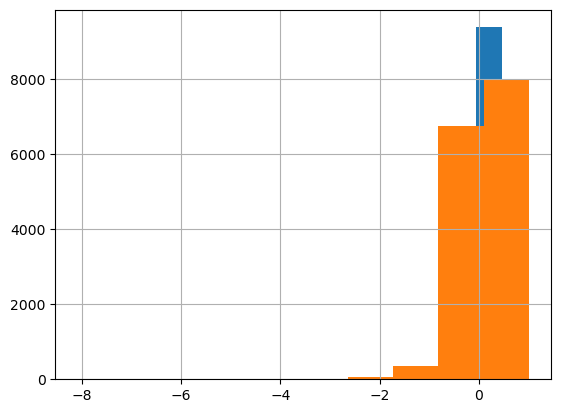

In [93]:
data22[data22['maxallwfar_22']!=0]['availfar_perc_22'].hist() 
data07[(data07['maxallwfar_07']!=0) & (data07['availfar_perc_07']>-10)]['availfar_perc_07'].hist() 

In [94]:
dfj = dfs.join( data07.set_index('bbl_07'), on='BBL_07', how='left' ).join( data22.set_index('bbl_22'), on='BBL_24', how='left' )
print( dfj.shape[0] , "<>", dfs.shape[0] )
dfj.head(3)

15343 <> 15343


,BBL_07,BBL_24,2007uc,2022uc,cd,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,xcoord_07,ycoord_07,availfar_07,availfar_perc_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,xcoord_22,ycoord_22,maxallwfar_22,availfar_22,availfar_perc_22
0,1009720001,1009720001,6179.0,8770.0,106,240 1 AVENUE,8756.0,8367942.0,8942176.0,3.34,3.44,0990379,0205835,0.10,0.02907,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,990376.0,205864.0,6.5,3.16,0.486154
1,1009780001,1009780001,1749.0,2480.0,106,342 1 AVENUE,2491.0,3102556.0,3122165.0,3.77,3.44,0990626,0206995,-0.33,-0.09593,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,990629.0,207012.0,6.5,2.73,0.420000
2,1010890003,1010897502,0.0,1212.0,104,533 11 AVENUE,1266.0,854683.0,854683.0,21.97,10.00,0984487,0216424,-11.97,-1.19700,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,984462.0,216453.0,10.0,-9.16,-0.916000


Calculate change  
`dfj` is the combined data set. Rent stabilization, pluto 07, 22

In [95]:
dfj['change_maxfar'] = dfj['maxallwfar_22'] - dfj['maxallwfar_07']
dfj['change_uc'] = dfj['2022uc'] - dfj['2007uc']
dfj['change_units'] = dfj['unitsres_22'] - dfj['unitsres_07']
dfj['change_resarea'] = dfj['resarea_22'] - dfj['resarea_07']
dfj['change_bldgarea'] = dfj['bldgarea_22'] - dfj['bldgarea_07']
dfj['change_availfar'] = dfj['builtfar_22'] - dfj['builtfar_07']
dfj['change_availfar_perc'] = dfj['availfar_perc_22'] - dfj['availfar_perc_07']

dfj['change_uc_cat'] = dfj['change_uc'].apply(lambda x: 'unchanged' if x == 0 else ('increase' if x > 0 else 'decrease'))

# do same for maxfar
dfj['change_maxfar_cat'] = dfj['change_maxfar'].apply(lambda x: 'unchanged' if x == 0 else ('increase' if x > 0 else 'decrease'))
dfj['change_availfar_cat'] = dfj['change_availfar'].apply(lambda x: 'unchanged' if x == 0 else ('increase' if x > 0 else 'decrease'))
dfj['change_availfar_perc_cat'] = dfj['change_availfar_perc'].apply(lambda x: 'unchanged' if x == 0 else ('increase' if x > 0 else 'decrease'))
dfj['change_combined'] = "Rent st: " + dfj['change_uc_cat'] + ' <> ' + "Avail FAR %: " +  dfj['change_availfar_perc_cat']

dfj['xcoord'] = dfj['xcoord_07'].combine_first( dfj['xcoord_22'] )
dfj['ycoord'] = dfj['ycoord_07'].combine_first( dfj['ycoord_22'] )
dfj = dfj[ dfj['xcoord'] != '       ' ].copy()
dfj = dfj.dropna( subset=['xcoord','ycoord'] )

dfj = dfj.drop( columns=['xcoord_07','ycoord_07','xcoord_22','ycoord_22'] )

dfj.head(3)

,BBL_07,BBL_24,2007uc,2022uc,cd,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,availfar_07,availfar_perc_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,maxallwfar_22,availfar_22,availfar_perc_22,change_maxfar,change_uc,change_units,change_resarea,change_bldgarea,change_availfar,change_availfar_perc,change_uc_cat,change_maxfar_cat,change_availfar_cat,change_availfar_perc_cat,change_combined,xcoord,ycoord
0,1009720001,1009720001,6179.0,8770.0,106,240 1 AVENUE,8756.0,8367942.0,8942176.0,3.34,3.44,0.10,0.02907,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,6.5,3.16,0.486154,3.06,2591.0,8.0,0.0,0.0,0.00,0.457084,increase,increase,unchanged,increase,Rent st: increase <> Avail FAR %: increase,0990379,0205835
1,1009780001,1009780001,1749.0,2480.0,106,342 1 AVENUE,2491.0,3102556.0,3122165.0,3.77,3.44,-0.33,-0.09593,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,6.5,2.73,0.420000,3.06,731.0,0.0,0.0,0.0,0.00,0.515930,increase,increase,unchanged,increase,Rent st: increase <> Avail FAR %: increase,0990626,0206995
2,1010890003,1010897502,0.0,1212.0,104,533 11 AVENUE,1266.0,854683.0,854683.0,21.97,10.00,-11.97,-1.19700,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.0,-9.16,-0.916000,0.00,1212.0,10.0,41307.0,99999.0,-2.81,0.281000,increase,unchanged,decrease,increase,Rent st: increase <> Avail FAR %: increase,0984487,0216424


For each bbl, one coord is enough. just incase if there are unmathced ones, I am filling missing ones.

In [96]:
geo_dfj = gpd.GeoDataFrame( dfj, geometry=gpd.points_from_xy( dfj['xcoord'], dfj['ycoord'] ) , crs=2263 )
geo_dfj.head()

,BBL_07,BBL_24,2007uc,2022uc,cd,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,availfar_07,availfar_perc_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,maxallwfar_22,availfar_22,availfar_perc_22,change_maxfar,change_uc,change_units,change_resarea,change_bldgarea,change_availfar,change_availfar_perc,change_uc_cat,change_maxfar_cat,change_availfar_cat,change_availfar_perc_cat,change_combined,xcoord,ycoord,geometry
0,1009720001,1009720001,6179.0,8770.0,106,240 1 AVENUE,8756.0,8367942.0,8942176.0,3.34,3.44,0.10,0.02907,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,6.5,3.16,0.486154,3.06,2591.0,8.0,0.0,0.0,0.00,0.457084,increase,increase,unchanged,increase,Rent st: increase <> Avail FAR %: increase,0990379,0205835,POINT (990379.000 205835.000)
1,1009780001,1009780001,1749.0,2480.0,106,342 1 AVENUE,2491.0,3102556.0,3122165.0,3.77,3.44,-0.33,-0.09593,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,6.5,2.73,0.420000,3.06,731.0,0.0,0.0,0.0,0.00,0.515930,increase,increase,unchanged,increase,Rent st: increase <> Avail FAR %: increase,0990626,0206995,POINT (990626.000 206995.000)
2,1010890003,1010897502,0.0,1212.0,104,533 11 AVENUE,1266.0,854683.0,854683.0,21.97,10.00,-11.97,-1.19700,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.0,-9.16,-0.916000,0.00,1212.0,10.0,41307.0,99999.0,-2.81,0.281000,increase,unchanged,decrease,increase,Rent st: increase <> Avail FAR %: increase,0984487,0216424,POINT (984487.000 216424.000)
3,1010890001,1010890001,0.0,921.0,104,640 WEST 42 STREET,921.0,788774.0,887879.0,8.07,10.00,1.93,0.19300,1 RIVER PLACE,1999.0,921.0,788774.0,887879.0,8.79,10.0,1.21,0.121000,0.00,921.0,0.0,0.0,0.0,0.72,-0.072000,increase,unchanged,increase,decrease,Rent st: increase <> Avail FAR %: decrease,0984257,0216528,POINT (984257.000 216528.000)
4,1001000001,1001007502,0.0,899.0,101,52 BEEKMAN STREET,0.0,0.0,301941.0,4.82,10.00,5.18,0.51800,8 SPRUCE STREET,2007.0,899.0,773169.0,900766.0,21.77,10.0,-11.77,-1.177000,0.00,899.0,899.0,773169.0,598825.0,16.95,-1.695000,increase,unchanged,increase,decrease,Rent st: increase <> Avail FAR %: decrease,0982767,0198173,POINT (982767.000 198173.000)


## PLOTS

<Axes: xlabel='recent_built', ylabel='change_uc'>

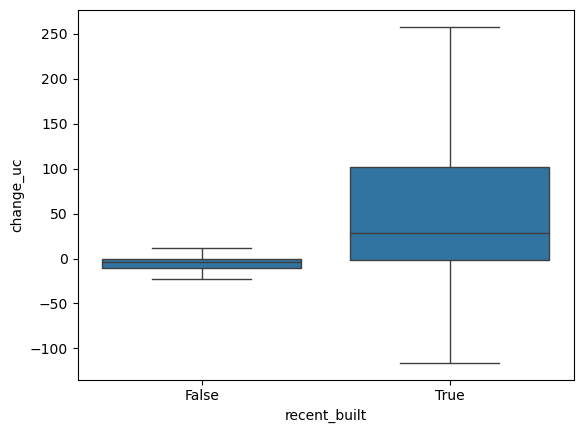

In [80]:
t = dfj[ dfj['change_uc'] != 0 ].copy()
t['recent_built'] = t['yearbuilt_22'] >= 2007

sns.boxplot(
    data = t,
    x = 'recent_built',
    y = 'change_uc',
    showfliers=False
)

Compare change Rent St with FAR (available and Max)

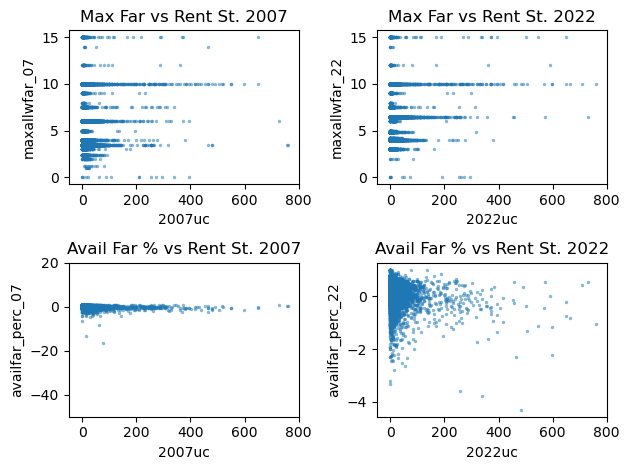

In [17]:
fig,axs = plt.subplots( ncols = 2, nrows = 2 )
axs = axs.flatten()

ax = axs[0]
sns.scatterplot( x='2007uc', y='maxallwfar_07', data=dfj, ax=ax , s=5, ec=None, alpha=0.5)
ax.set_title('Max Far vs Rent St. 2007') 
ax.set_xlim( -50, 800 )

ax = axs[1]
sns.scatterplot( x='2022uc', y='maxallwfar_22', data=dfj, ax=ax, s=5, ec=None, alpha=0.5 )
ax.set_title('Max Far vs Rent St. 2022') 
ax.set_xlim( -50, 800 )

ax = axs[2]
sns.scatterplot( x='2007uc', y='availfar_perc_07', data=dfj, ax=ax, s=5, ec=None, alpha=0.5 )
ax.set_title('Avail Far % vs Rent St. 2007') 
ax.set_xlim( -50, 800 )
ax.set_ylim( -50, 20 )

ax = axs[3]
sns.scatterplot( x='2022uc', y='availfar_perc_22', data=dfj, ax=ax, s=5, ec=None, alpha=0.5 )
ax.set_title('Avail Far % vs Rent St. 2022')
ax.set_xlim( -50, 800 )


fig.tight_layout()

Text(0.5, 1.0, 'Change in Avail Far % vs Change in Rent St.')

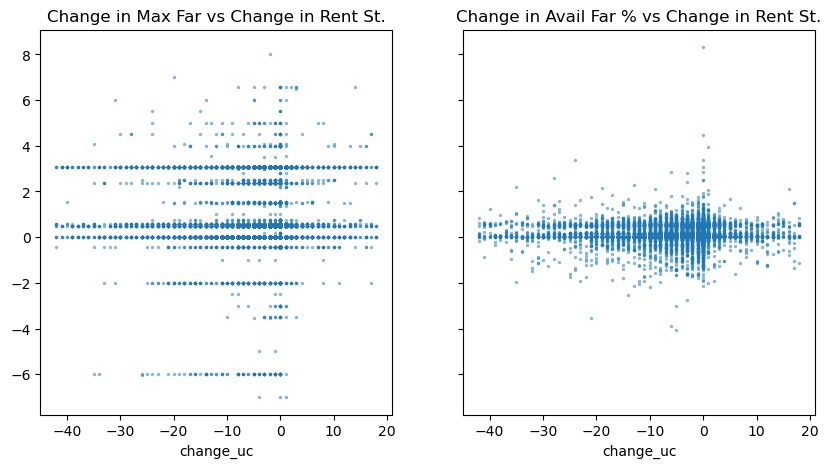

In [24]:

fig,axs = plt.subplots( ncols = 2, sharey=True, sharex=True, figsize=(10,5) )

ax = axs[0]
sns.scatterplot( 
    data=dfj[ 
        (dfj['change_uc'] < dfj['change_uc'].quantile(0.975)) & 
        (dfj['change_uc'] > dfj['change_uc'].quantile(0.025)) & 
        (dfj['change_uc'] < 1000 )
        ], # filter out the outliers
    ax=ax,
    x='change_uc', 
    y='change_maxfar', 
    s=5, ec=None, alpha=0.5 )

ax.set_title('Change in Max Far vs Change in Rent St.')
ax.set_ylabel('')

ax = axs[1]
sns.scatterplot( 
    data=dfj[ 
        (dfj['change_uc'] < dfj['change_uc'].quantile(0.975)) &
        (dfj['change_uc'] > dfj['change_uc'].quantile(0.025)) &
        (dfj['change_availfar']>-40) 
    ], # filter out the outliers
    ax=ax,
    x='change_uc', 
    y='change_availfar_perc', 
    s=5, ec=None, alpha=0.5 )

ax.set_ylabel('Change in Avail Far')
ax.set_title('Change in Avail Far % vs Change in Rent St.')


Simplify data to `increase, no change and decrease` since the data is lot scale, maybe that is enough.

Compare max and avail far vales for rent st increase or decrease.  
I am seeing very slight change here. We can calculate a `p-value` here to test stat significance but not sure

Text(0.5, 1.0, 'Change in Rent St. vs Change in Avail Far %')

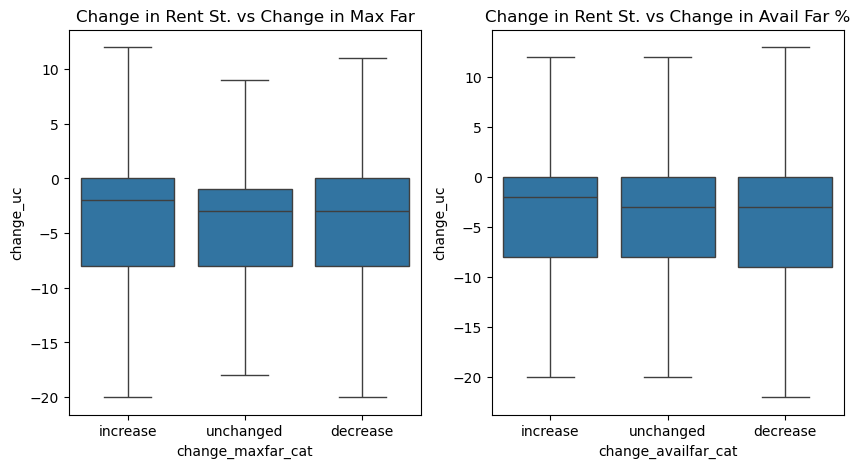

In [29]:
fig,axs = plt.subplots( figsize=(10,5) , ncols=2 )

ax= axs[0]
col = 'change_maxfar'
sns.boxplot(
    data=dfj[(dfj[col] > dfj[col].quantile(0.01)) & (dfj[col]<dfj[col].quantile(0.99))], ax=ax,
    x='change_maxfar_cat',
    y='change_uc',
    showfliers=False,
    # xorder is increase, unchanged, decrease
    order=['increase','unchanged','decrease']

)
ax.set_title('Change in Rent St. vs Change in Max Far')

ax = axs[1]
col = 'change_availfar_perc'
sns.boxplot(
    data=dfj[(dfj[col] > dfj[col].quantile(0.01)) & (dfj[col]<dfj[col].quantile(0.99)) ], ax=ax,
    x='change_availfar_cat',
    y='change_uc',
    showfliers=False,
    order=['increase','unchanged','decrease']
)
ax.set_title('Change in Rent St. vs Change in Avail Far %')


## in CD

In [81]:
cd = dfj[ 
        (dfj['change_uc'] < dfj['change_uc'].quantile(0.99)) &
        (dfj['change_uc'] > dfj['change_uc'].quantile(0.01) ) &
        (dfj['change_availfar']>-100) &
        (dfj['change_availfar_perc'].between(-10,10) ) & 
        (dfj['yearbuilt_22'] > 2007 )
    ].groupby('cd', as_index=False).agg({
    'maxallwfar_07': 'sum',
    'maxallwfar_22': 'sum',
    'availfar_07': 'sum',
    'availfar_22': 'sum',
    '2007uc': 'sum',
    '2022uc': 'sum',
    'change_maxfar': 'sum',
    'change_uc': 'sum',
    'change_availfar': 'sum',
    'change_availfar_perc': 'sum'
})

cd

,cd,maxallwfar_07,maxallwfar_22,availfar_07,availfar_22,2007uc,2022uc,change_maxfar,change_uc,change_availfar,change_availfar_perc
0,101,42.04,43.00,28.42,-5.60,0.0,129.0,0.96,129.0,34.98,-4.108961
1,102,42.02,49.50,33.33,-14.21,13.0,29.0,7.48,16.0,55.02,-6.132536
2,103,73.28,85.00,35.96,-10.68,80.0,354.0,11.72,274.0,58.36,-11.607500
3,104,120.16,143.52,85.80,-46.01,359.0,537.0,23.36,178.0,155.17,-15.134267
4,105,125.00,135.00,72.17,-67.79,62.0,44.0,10.00,-18.0,149.96,-13.659000
5,106,146.04,147.00,105.46,-62.67,97.0,195.0,0.96,98.0,169.09,-17.797452
6,107,41.52,44.00,35.93,2.30,16.0,64.0,2.48,48.0,36.11,-4.385170
7,108,329.00,330.50,202.35,-93.01,230.0,22.0,1.50,-208.0,296.86,-30.358231
8,109,16.34,18.50,16.34,-3.31,92.0,118.0,2.16,26.0,21.81,-4.612115
9,110,110.50,158.50,67.42,23.41,50.0,439.0,48.00,389.0,92.01,-12.498644


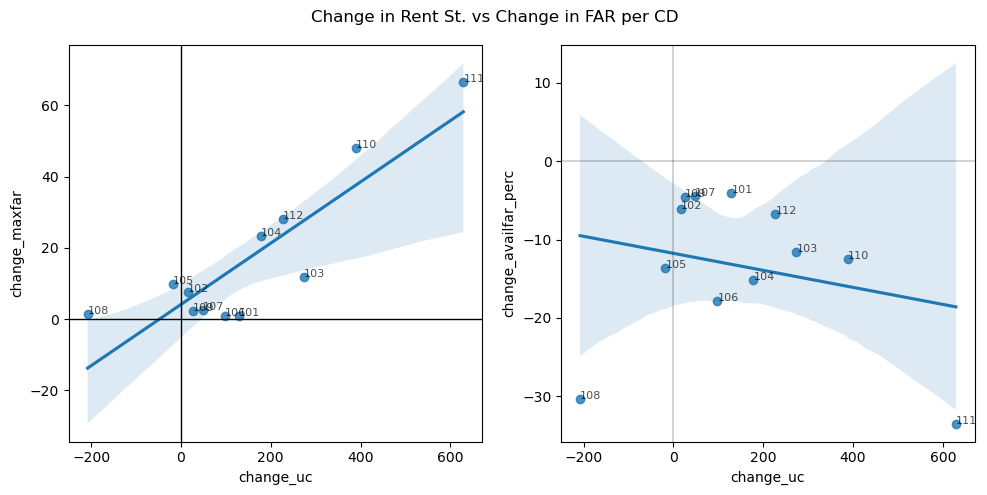

In [55]:
fig,axs = plt.subplots( figsize=(10,5) , ncols=2 )
ax = axs[0]
sns.regplot(
    data=cd, ax=ax,
    x='change_uc',
    y='change_maxfar'
    )

ax.axhline(0, color='black', lw=1)
ax.axvline(0, color='black', lw=1)

ax = axs[1]
sns.regplot(
    data=cd, ax=ax,
    x='change_uc',
    y='change_availfar_perc'
    )

ax.axhline(0, color='black', lw=0.25)
ax.axvline(0, color='black', lw=0.25)

for i, row in cd.iterrows():
    axs[0].text(row['change_uc'], row['change_maxfar'], str(row['cd']), fontsize=8, alpha=0.7)
    axs[1].text(row['change_uc'], row['change_availfar_perc'], str(row['cd']), fontsize=8, alpha=0.7)

fig.suptitle( "Change in Rent St. vs Change in FAR per CD" )
fig.tight_layout()

## Mapping

In [97]:
geo_dfj = gpd.GeoDataFrame( dfj, geometry=gpd.points_from_xy( dfj['xcoord'], dfj['ycoord'] ) , crs=2263 )
geo_dfj['recent_built'] = geo_dfj['yearbuilt_22'] >= 2007
geo_dfj.head(3)

,BBL_07,BBL_24,2007uc,2022uc,cd,address_07,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,availfar_07,availfar_perc_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,maxallwfar_22,availfar_22,availfar_perc_22,change_maxfar,change_uc,change_units,change_resarea,change_bldgarea,change_availfar,change_availfar_perc,change_uc_cat,change_maxfar_cat,change_availfar_cat,change_availfar_perc_cat,change_combined,xcoord,ycoord,geometry,recent_built
0,1009720001,1009720001,6179.0,8770.0,106,240 1 AVENUE,8756.0,8367942.0,8942176.0,3.34,3.44,0.10,0.02907,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,6.5,3.16,0.486154,3.06,2591.0,8.0,0.0,0.0,0.00,0.457084,increase,increase,unchanged,increase,Rent st: increase <> Avail FAR %: increase,0990379,0205835,POINT (990379.000 205835.000),False
1,1009780001,1009780001,1749.0,2480.0,106,342 1 AVENUE,2491.0,3102556.0,3122165.0,3.77,3.44,-0.33,-0.09593,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,6.5,2.73,0.420000,3.06,731.0,0.0,0.0,0.0,0.00,0.515930,increase,increase,unchanged,increase,Rent st: increase <> Avail FAR %: increase,0990626,0206995,POINT (990626.000 206995.000),False
2,1010890003,1010897502,0.0,1212.0,104,533 11 AVENUE,1266.0,854683.0,854683.0,21.97,10.00,-11.97,-1.19700,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.0,-9.16,-0.916000,0.00,1212.0,10.0,41307.0,99999.0,-2.81,0.281000,increase,unchanged,decrease,increase,Rent st: increase <> Avail FAR %: increase,0984487,0216424,POINT (984487.000 216424.000),False


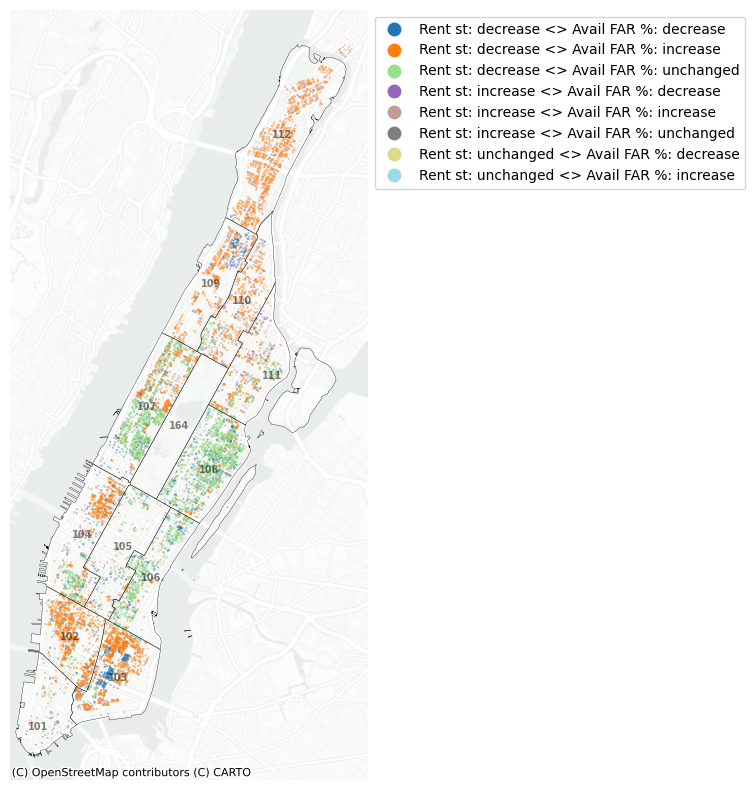

In [98]:
import contextily as ctx

geo_cd = gpd.read_file( r"D:\DATA\Community Districts.geojson" )
geo_cd = geo_cd[ geo_cd['boro_cd'].str.startswith('1') ].copy()
geo_cd = geo_cd.to_crs(3857)

fig,ax = plt.subplots( figsize=(10,10) )

t = geo_dfj[ ~((geo_dfj['change_uc_cat'] == 'unchanged') & (geo_dfj['change_availfar_cat'] == 'unchanged')) ]
t = t[ t['change_availfar_perc'].between(-100,100) ].copy()
t = t.to_crs(3857)

t.plot( ax=ax, column='change_combined', marker='o', markersize=0.05,
       cmap='tab20', legend=True, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)} )

ctx.add_basemap( ax=ax, source=ctx.providers.CartoDB.PositronNoLabels , alpha=0.5 )

geo_cd.plot( ax=ax, edgecolor='black', facecolor='none', lw=0.25 )
# label the community districts
for i, row in geo_cd.iterrows():
    plt.text( row['geometry'].centroid.x, row['geometry'].centroid.y, row['boro_cd'], fontsize=7, alpha=0.5, fontweight='bold', ha='center', va='center' )

ax.axis('off');


Text(0.5, 1.0, 'Rent St. Change vs FAR Change\nfor not Built after 2007')

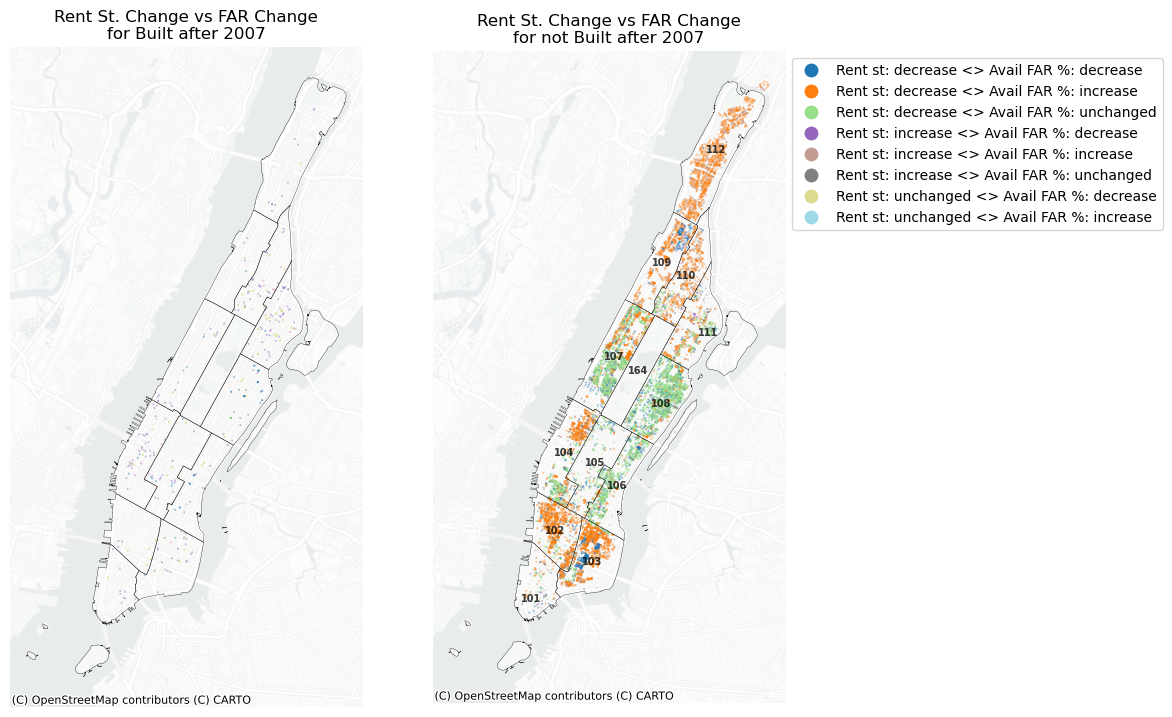

In [107]:
import contextily as ctx

geo_cd = gpd.read_file( r"D:\DATA\Community Districts.geojson" )
geo_cd = geo_cd[ geo_cd['boro_cd'].str.startswith('1') ].copy()
geo_cd = geo_cd.to_crs(3857)

bounds = geo_cd.total_bounds


fig,axs = plt.subplots( figsize=(10,10) , ncols = 2)

ax = axs[0]
t = geo_dfj[ ~((geo_dfj['change_uc_cat'] == 'unchanged') & (geo_dfj['change_availfar_cat'] == 'unchanged')) ]
t = t[ t['change_availfar_perc'].between(-100,100) ]
t = t[ t['recent_built'] == True ].copy()
t = t.to_crs(3857)

t.plot( ax=ax, column='change_combined', marker='o', markersize=0.05,
       cmap='tab20', legend=False)
geo_cd.plot( ax=ax, edgecolor='black', facecolor='none', lw=0.25 )
# label the community districts
for i, row in geo_cd.iterrows():
    plt.text( row['geometry'].centroid.x, row['geometry'].centroid.y, row['boro_cd'], fontsize=7, alpha=0.5, fontweight='bold', ha='center', va='center' )

ax.axis('off')

ctx.add_basemap( ax=ax, source=ctx.providers.CartoDB.PositronNoLabels , alpha=0.5 )
ax.set_title('Rent St. Change vs FAR Change\nfor Built after 2007')    


ax = axs[1]
t = geo_dfj[ ~((geo_dfj['change_uc_cat'] == 'unchanged') & (geo_dfj['change_availfar_cat'] == 'unchanged')) ]
t = t[ t['change_availfar_perc'].between(-100,100) ]
t = t[ t['recent_built'] == False ].copy()

t = t.to_crs(3857)

t.plot( ax=ax, column='change_combined', marker='o', markersize=0.05,
       cmap='tab20', legend=True, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)} )
geo_cd.plot( ax=ax, edgecolor='black', facecolor='none', lw=0.25 )

# label the community districts

for i, row in geo_cd.iterrows():
    plt.text( row['geometry'].centroid.x, row['geometry'].centroid.y, row['boro_cd'], fontsize=7, alpha=0.5, fontweight='bold', ha='center', va='center' )

ax.axis('off')

ctx.add_basemap( ax=ax, source=ctx.providers.CartoDB.PositronNoLabels , alpha=0.5 )

ax.set_title('Rent St. Change vs FAR Change\nfor not Built after 2007')    



In [49]:
cd_table = geo_dfj.pivot_table(
    index='cd',
    columns='change_combined',
    aggfunc='count',
    values='BBL_07',
)

cd_table_percentage = cd_table.div(cd_table.sum(axis=1), axis=0)
cd_table_percentage

change_combined,Rent st: decrease <> FAR: decrease,Rent st: decrease <> FAR: increase,Rent st: decrease <> FAR: unchanged,Rent st: increase <> FAR: decrease,Rent st: increase <> FAR: increase,Rent st: increase <> FAR: unchanged,Rent st: unchanged <> FAR: decrease,Rent st: unchanged <> FAR: increase,Rent st: unchanged <> FAR: unchanged
cd,,,,,,,,,
101,0.013333,0.213333,0.273333,NaN,0.073333,0.140000,0.006667,0.173333,0.106667
102,0.008178,0.688476,0.046840,0.001487,0.097398,0.005948,0.001487,0.133829,0.016357
103,0.109920,0.526005,0.044504,0.009651,0.110456,0.015550,0.026273,0.134584,0.023056
104,0.011438,0.426471,0.274510,0.003268,0.084150,0.046569,0.001634,0.102941,0.049020
105,0.020253,0.149367,0.544304,0.002532,0.022785,0.093671,0.002532,0.030380,0.134177
106,0.025490,0.061765,0.735294,0.003922,0.010784,0.054902,0.001961,0.008824,0.097059
107,0.007433,0.194141,0.558373,0.000437,0.023174,0.059904,0.003498,0.043725,0.109314
108,0.035375,0.029336,0.767472,0.001294,0.005177,0.059534,0.006903,0.003451,0.091458
109,0.111111,0.442177,NaN,0.038549,0.148526,0.002268,0.070295,0.187075,NaN


Text(95.7222222222222, 0.5, '')

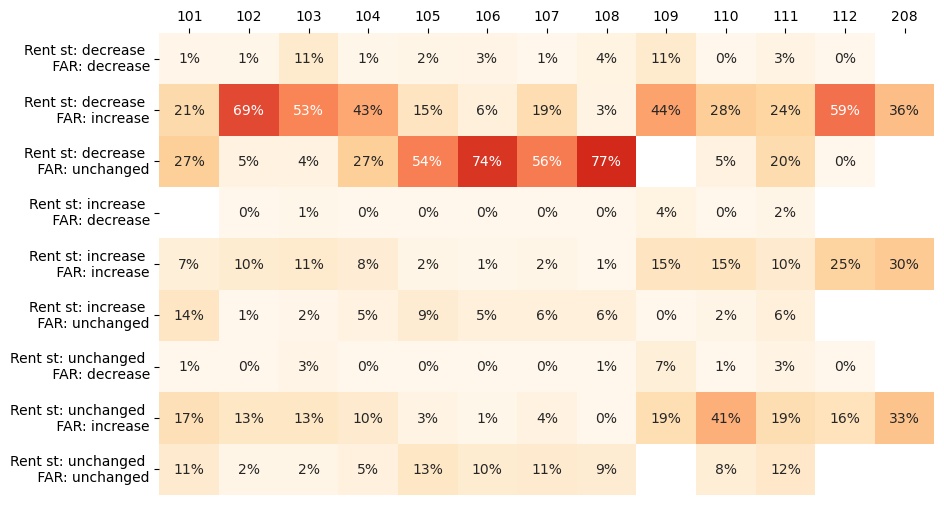

In [50]:
fig,ax = plt.subplots( figsize=(10,6) )
sns.heatmap(
    ax=ax,
    data = cd_table_percentage.T,
    cmap='OrRd',
    annot=True,
    fmt=".0%",
    vmin=0, vmax=1,
    cbar=False
)

# put x-axis labels on top
ax.xaxis.tick_top()

ylabels = ax.get_yticklabels()
ylabels = [i.get_text().replace("<>","\n") for i in ylabels]
ax.set_yticklabels( ylabels )

ax.set_xlabel('')
ax.set_ylabel('')

## Rezonings

In [54]:
dataUrl = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/nyzma/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
rezone = gpd.read_file( dataUrl )
rezone = rezone.set_crs(4326)
rezone = rezone.to_crs(2263)
rezone - rezone[ rezone['STATUS'] == 'Adopted' ].copy()
rezone['datetime'] = pd.to_datetime(rezone['EFFECTIVE'], unit='ms')
rezone = rezone[ rezone['datetime'].dt.year >= 2007 ].copy()
print( rezone.shape[0] )
rezone.head(3)


C:\Users\cansu\AppData\Local\Temp\ipykernel_17816\2233248583.py:5: FutureWarning: '-' operator will be deprecated. Use the 'difference' method instead.
  rezone - rezone[ rezone['STATUS'] == 'Adopted' ].copy()


540


,OBJECTID,EFFECTIVE,STATUS,ULURPNO,LUCATS,PROJECT_NAME,Shape__Area,Shape__Length,geometry,datetime
0,1,1.552435e+12,Adopted,060432zmq,060432,Douglaston Parkway Rezoning,157598.778640,1969.212699,"POLYGON ((1054403.275 218666.790, 1054438.937 ...",2019-03-13
1,2,1.255478e+12,Adopted,060551zmq,060551,BRIARWOOD PLAZA,29679.878052,735.793336,"POLYGON ((1047145.104 218925.009, 1047385.647 ...",2009-10-14
2,3,1.256688e+12,Adopted,060419zmq,060419,SOUTH CONDUIT REZONING,38034.872589,820.472092,"POLYGON ((1054113.461 181836.300, 1054297.621 ...",2009-10-28


In [55]:
geo_dfj = gpd.GeoDataFrame( dfj, geometry=gpd.points_from_xy( dfj['xcoord'], dfj['ycoord'] ) , crs=2263 )

print( geo_dfj.shape[0] )

geo_dfj = gpd.sjoin( geo_dfj, rezone[['PROJECT_NAME','geometry']], predicate='within', how='left' )

geo_dfj['is_rezoned'] = geo_dfj['index_right'].notnull()

print( geo_dfj.shape[0] )

# geo_dfj.head(3)

15311
15424


<Axes: xlabel='is_rezoned', ylabel='change_uc'>

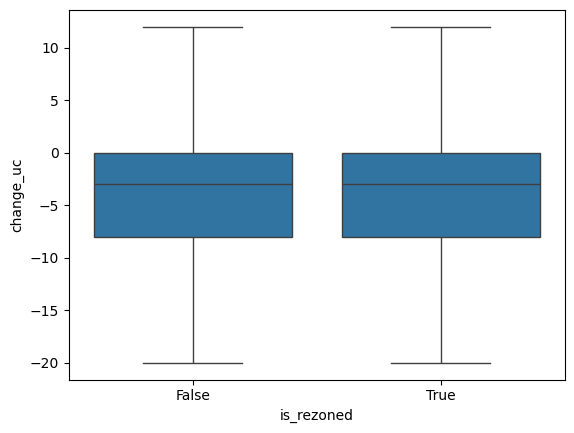

In [56]:
sns.boxplot( data=geo_dfj, x='is_rezoned', y='change_uc', showfliers=False )

<Axes: xlabel='change_uc', ylabel='change_availfar'>

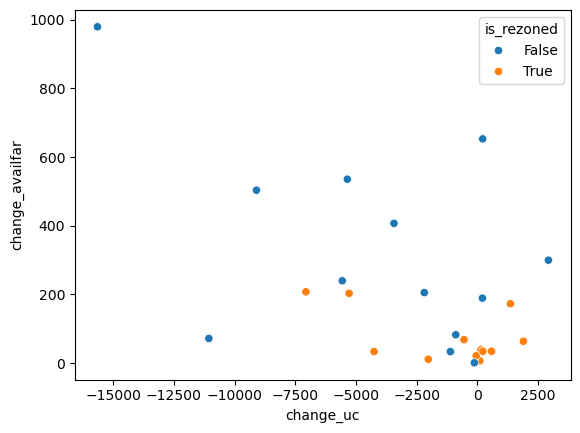

In [ ]:
gr = geo_dfj[
    geo_dfj['change_availfar'] > geo_dfj['change_availfar'].quantile(0.01)
].groupby(['cd','is_rezoned']).agg({
    "change_uc": "sum",
    "change_maxfar": "sum",
    "change_availfar": "sum"
})

sns.scatterplot(
    data=gr,
    x='change_uc',
    y='change_availfar',
    hue='is_rezoned'
)


## Per Cd